## Local Ensembles Demo

In this notebook, we demonstrate a toy example of the method from _Detecting Extrapolation with Local Ensembles_ by David Madras, James Atwood, and Alex D'Amour.
We train an ensemble of small two-layer neural networks on some one-dimensional data.
Then, for one of these models, we use local ensembles to detect which points are out-of-distribution.
We show how to use the Lanczos iteration to estimate the largest-eigenvalued eigenvectors of the Hessian, and how to use these to compute an extrapolation score.
We also explore to what degree this score correlates with the ensemble variance.

For better results here, we should average the extrapolation scores across the entire ensemble --- we don't do that in this notebook for convenience. See local_ensembles_demo.py to reproduce the toy data ensemble results from the paper.

In [1]:
# IMPORTS
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg
import tensorflow as tf
from utils import tensor_utils as tu
import local_ensembles_demo_lib as LE
from local_ensembles import evaluation_functions as eval_fns
from local_ensembles import lanczos_functions as L
from local_ensembles import second_order as so

from utils import utils
import os
mainfigdir = 'test_git_figs/'
figdir = utils.make_subdir(mainfigdir, 'tanh')

In [2]:
# random seeding
seed = 12345
tf.compat.v1.random.set_random_seed(seed)
np.random.seed(seed)

# plotting hyperparameters
legendsize=20
ticksize=22
markersize=30

# training hyperparameters
n_models = 3 # ensemble size
n_steps = 400 # length of optimization
activ = 'tanh' # activation function
hidden_layer_sizes = [3, 3]

Generate some 1-D data.

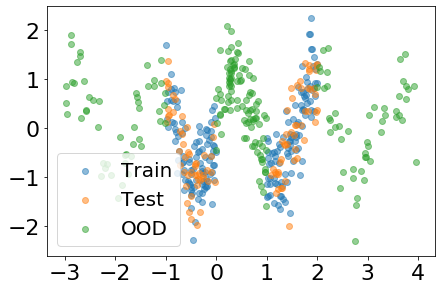

In [3]:
itr_train, itr_test, itr_ood = LE.setup_data_1d(figdir, legendsize=legendsize, ticksize=ticksize)

Train an ensemble of models on this data, and calculate its standard deviation.

Step 0: Test loss = 1.44, Train loss = 1.02, OOD loss = 1.26
Step 20: Test loss = 0.57, Train loss = 0.71, OOD loss = 1.42
Step 40: Test loss = 0.58, Train loss = 0.55, OOD loss = 0.76
Step 60: Test loss = 0.51, Train loss = 0.46, OOD loss = 1.22
Step 80: Test loss = 0.63, Train loss = 0.60, OOD loss = 1.01
Step 100: Test loss = 0.74, Train loss = 0.35, OOD loss = 1.32
Step 120: Test loss = 0.41, Train loss = 0.44, OOD loss = 1.03
Step 140: Test loss = 0.57, Train loss = 0.59, OOD loss = 1.37
Step 160: Test loss = 0.28, Train loss = 0.34, OOD loss = 1.57
Step 180: Test loss = 0.38, Train loss = 0.46, OOD loss = 2.58
Step 200: Test loss = 0.42, Train loss = 0.34, OOD loss = 1.92
Step 220: Test loss = 0.34, Train loss = 0.44, OOD loss = 1.87
Step 240: Test loss = 0.31, Train loss = 0.24, OOD loss = 3.03
Step 260: Test loss = 0.54, Train loss = 0.44, OOD loss = 3.53
Step 280: Test loss = 0.29, Train loss = 0.34, OOD loss = 3.01
Step 300: Test loss = 0.45, Train loss = 0.22, OOD loss = 2.6

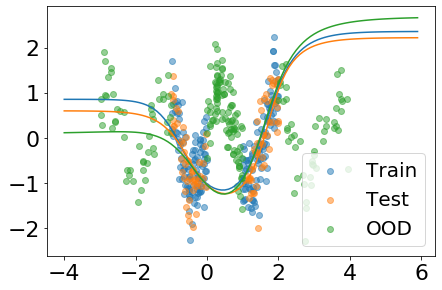

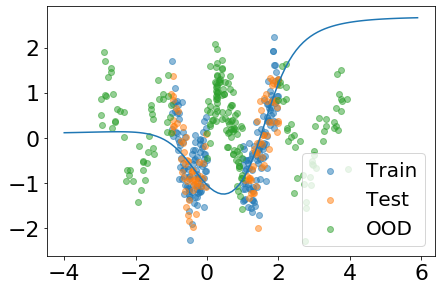

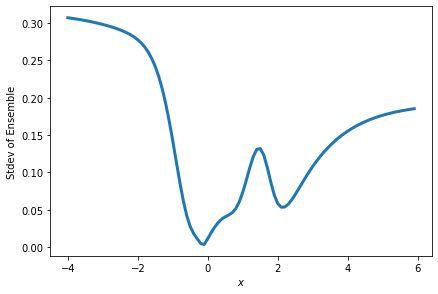

In [4]:
ensemble = []

for _ in range(n_models):
    model_i = LE.train_NN(itr_train, itr_test, itr_ood, 1, n_steps, activ, hidden_layer_sizes)
    ensemble.append(model_i)
LE.plot_data_1d_ensemble(ensemble, itr_train, itr_test, itr_ood,
                              figdir, legendsize=legendsize, ticksize=ticksize)

model = model_i
LE.plot_data_1d(model, itr_train, itr_test, itr_ood, figdir, legendsize=legendsize, ticksize=ticksize)

# plot std dev of ensemble
outputs = []
xrange = np.expand_dims(np.arange(-4, 6, 0.1), 1)
for mdl in ensemble:
    xrange_output, _ = mdl(xrange)
    outputs.append(xrange_output)
outputs = tf.concat(outputs, axis=1)
output_stdev = np.std(outputs, axis=1)
plt.plot(xrange, output_stdev, lw=3)
# plt.xticks(fontsize=ticksize)
# plt.yticks(fontsize=ticksize)
plt.tight_layout()
plt.xlabel('$x$')
plt.ylabel('Stdev of Ensemble')
plt.show()

Choose one model from the ensemble, and compute its Hessian exactly.
We will not do this for larger models; here we just want to check the accuracy of our method.

In [5]:
model = ensemble[0]
hessian = LE.estimate_Hessian(model, itr_train)
assert np.linalg.norm(hessian - hessian.T) < 1e-8 # check you estimated a symmetrical Hessian
A = hessian
dim = hessian.shape[0]

# get the true eigendecomposition of the Hessian
true_evals, true_evecs = np.linalg.eig(A)
print(true_evals)
for i in range(dim):
    v = true_evecs[:, i]
    w = np.matmul(A, v)
    assert np.linalg.norm(w - true_evals[i] * v) < 1e-10 # assert it's correct

W0925 09:11:12.162617 140713342179136 backprop.py:968] Calling GradientTape.gradient on a persistent tape inside its context is significantly less efficient than calling it outside the context (it causes the gradient ops to be recorded on the tape, leading to increased CPU and memory usage). Only call GradientTape.gradient inside the context if you actually want to trace the gradient in order to compute higher order derivatives.


Estimating Hessian: minibatch 0
Estimating Hessian: minibatch 1
Estimating Hessian: minibatch 2
Estimating Hessian: minibatch 3
Estimating Hessian: minibatch 4
Estimating Hessian: minibatch 5
Estimating Hessian: minibatch 6
Estimating Hessian: minibatch 7
Estimating Hessian: minibatch 8
Estimating Hessian: minibatch 9
Taking second derivative - this may be slow...
[ 4.20479516e+01  8.12114638e+00  9.31711696e-01  2.74294793e-01
 -1.84429952e-01  1.61011265e-01  1.51448612e-01  1.37170127e-01
 -1.31571014e-01 -1.01500241e-01 -9.27189696e-02  8.82747176e-02
  7.28333887e-02 -2.60896976e-02 -1.83149575e-02  1.73348496e-02
  1.46010542e-02 -3.39810961e-03  3.47635862e-03 -9.16440034e-04
  1.49825861e-03  2.11905156e-04]


Having estimated the true Hessian, we can now test our implicit Hessian-vector product function (HVP) against the true HVP.

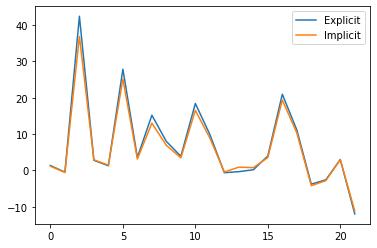

In [6]:
pred_fn = so.make_pred_fn(model, 'MLP_regressor')
loss_fn = so.make_loss_fn(model, None)
grad_fn = so.make_grad_fn(model)
map_grad_fn = so.make_map_grad_fn(model)
explicit_hvp = lambda v: np.matmul(A, v)

def implicit_hvp(v):
    v = tu.reshape_vector_as(model.weights, v.T)
    hvp = so.hvp(v, itr_train, loss_fn, grad_fn, map_grad_fn, n_samples=10)
    hvp_concat = tu.flat_concat(hvp)
    return tf.transpose(hvp_concat).numpy()

# test that implicit ~= explicit HVP
q = np.random.rand(dim, 1)
qe = explicit_hvp(q)
qi = implicit_hvp(q)
plt.plot(qe, label='Explicit')
plt.plot(qi, label='Implicit')
plt.legend()
plt.show()

# Lanczos iteration

Here, we run the Lanczos iteration to estimate the eigenvectors of this models Hessian (called _A_ below) with the largest eigenvalues.
For free, we'll also get the eigenvalues, but we don't use them in the local ensembles method.
We'll run Lanczos to convergence, which we won't be able to do on larger models.
The algorithm only requires implicit access to the Hessian, so we use our implicit HVP function from above.


In [7]:
# run the Lanczos algorithm
EPS = 1e-8
num_iters = dim

A_evals_all = []
A_evecs_all = []
Q, Beta, Alpha = L.lanczos_iteration(implicit_hvp, dim, num_iters,
                                     eps=EPS, two_reorth=True, dtype=np.float64)
Q_lan = np.concatenate(Q[1:-1], axis=1)
# find these eigenvalues + vectors from the tridiagonalized matrix
T_evals, T_evecs = L.get_eigendecomposition_from_tridiagonal(Alpha[1:], Beta[1:-1])
T_evals, T_evecs = L.sort_eigendata_by_absolute_value(T_evals, T_evecs)

# if algorithm terminated early, remove smallest estimate
if Beta[-1] < EPS:
    T_evals = T_evals[:-1]
    T_evecs = T_evecs[:,:-1]

# and derive the eigenvectors of A from the eigenvectors of T
A_evecs = np.matmul(Q_lan, T_evecs)
_, A_evecs = L.sort_eigendata_by_absolute_value(T_evals, A_evecs)
# A and T will have the same eigenvalues
A_evals = T_evals[:]
A_evals_all.append(A_evals)
A_evecs_all.append(A_evecs)





1 Lanczos iterations complete.


Now, we check how good our estimates of the eigenvalues and eigenvectors were.

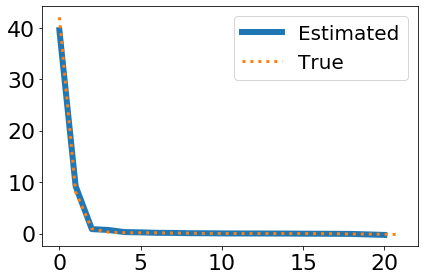

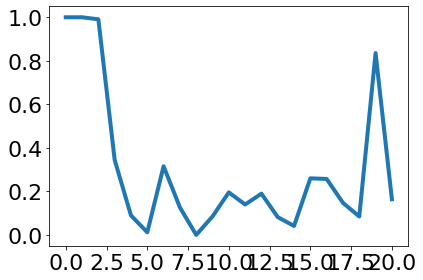

In [8]:
# PLOTTING ESTIMATED EIGENVALUES
true_evals, true_evecs = L.sort_eigendata_by_absolute_value(true_evals, true_evecs)

# plot to see my estimated eigenvalues are correct
plt.plot(sorted(T_evals, reverse=True), label='Estimated', lw=6, ls='-')
plt.plot(sorted(true_evals, reverse=True), label='True', lw=3, ls=':')
plt.legend(prop={'size': legendsize})
plt.xticks(fontsize=ticksize)
plt.yticks(fontsize=ticksize)
plt.tight_layout()
plt.savefig(os.path.join(figdir, 'eigenvalue_accuracy.pdf'))
plt.show()

# plot the cosine similarity of every estimated eigenvector to the ground-truth eigenvector.
angles = []
for i in range(len(T_evals)):
    vec_A = A_evecs[:,i]
    vec_true = true_evecs[:, i]
    angle = np.matmul(vec_A, vec_true)
    angles.append(abs(angle))
plt.plot(angles, lw=4)
plt.xticks(fontsize=ticksize)
plt.yticks(fontsize=ticksize)
plt.tight_layout()
plt.show()

Now, we can calculate our extrapolation score, which estimates the variance of a local ensemble around the trained model.
The score estimates the norm of the influence function --- the inverted Hessian times the gradient of the test point.
We'll estimate this by projecting the gradient onto just the largest-eigenvalued eigenvectors (estimated above) and subtracting that out, leaving us with the projection onto the small-eigenvalued eigenvectors, which we hypothesize are the dominant terms.

For different models, the optimal number of estimated eigenvalues will change --- it is an open question what this number should be for a given problem.

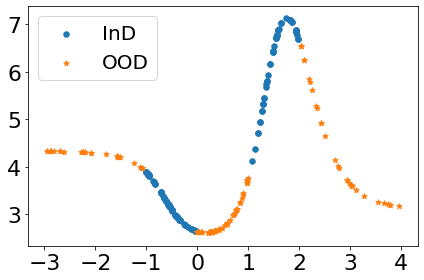

0 E-vecs: AUC = 0.33


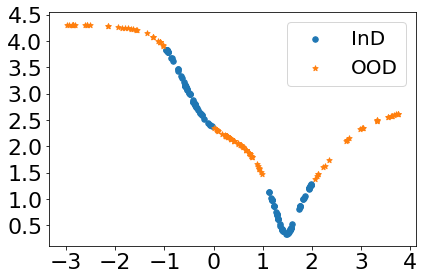

1 E-vecs: AUC = 0.65


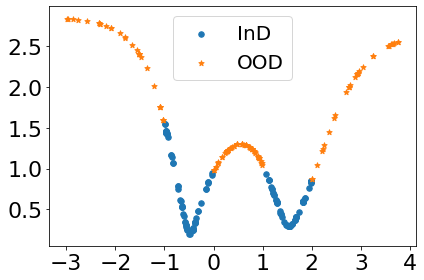

2 E-vecs: AUC = 0.94


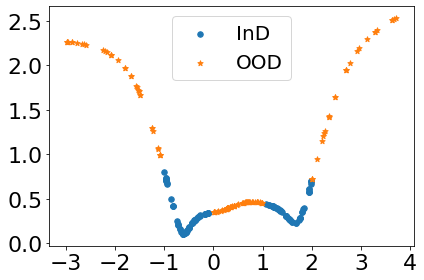

3 E-vecs: AUC = 0.88


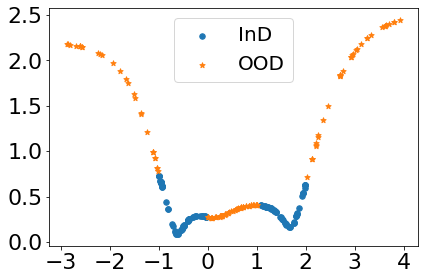

4 E-vecs: AUC = 0.79


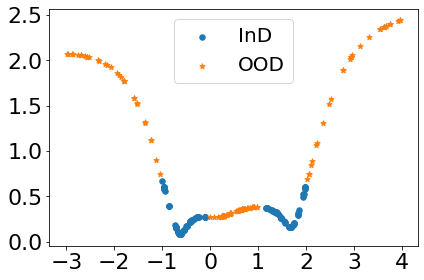

5 E-vecs: AUC = 0.85


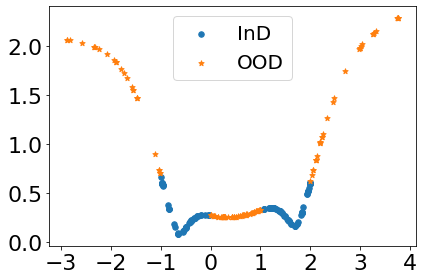

6 E-vecs: AUC = 0.71


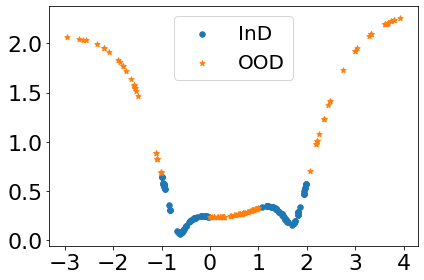

7 E-vecs: AUC = 0.74


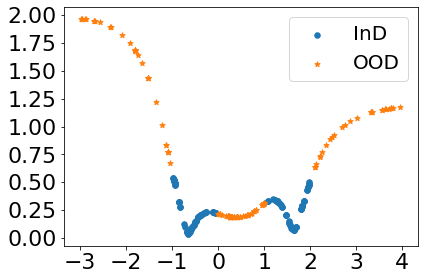

8 E-vecs: AUC = 0.72


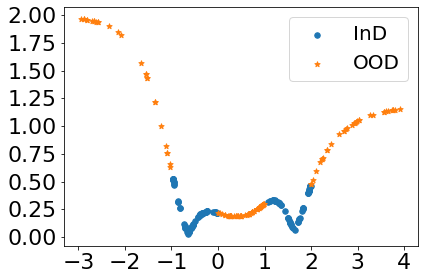

9 E-vecs: AUC = 0.72


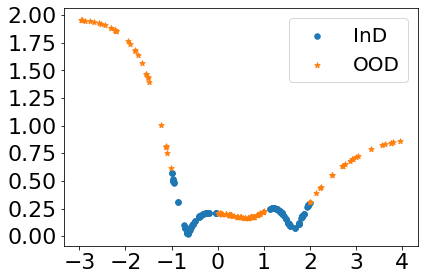

10 E-vecs: AUC = 0.71


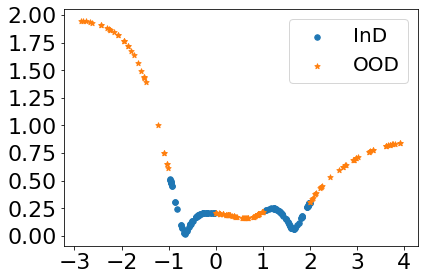

11 E-vecs: AUC = 0.75


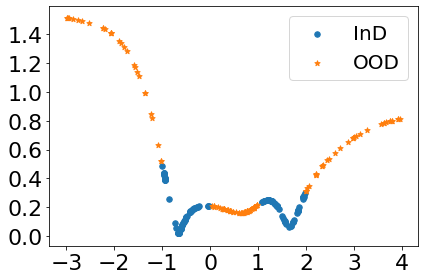

12 E-vecs: AUC = 0.72


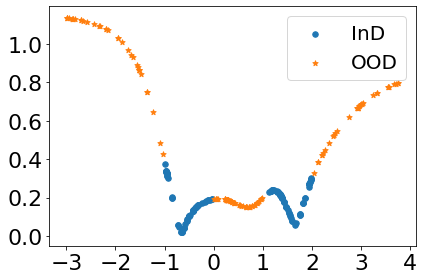

13 E-vecs: AUC = 0.76


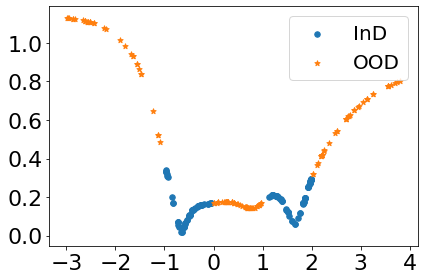

14 E-vecs: AUC = 0.79


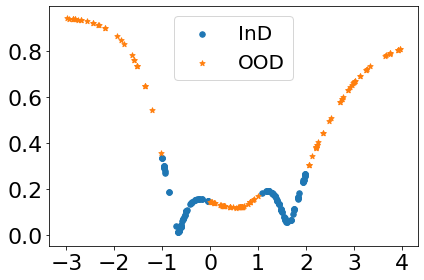

15 E-vecs: AUC = 0.77


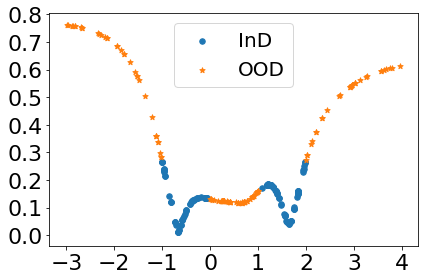

16 E-vecs: AUC = 0.72


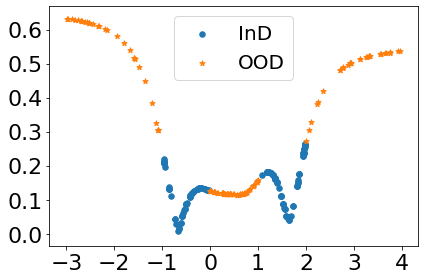

17 E-vecs: AUC = 0.70


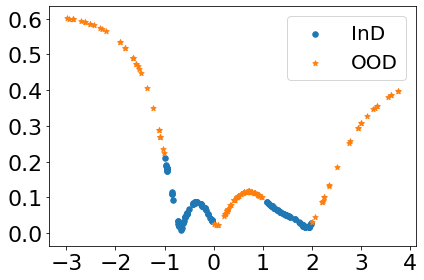

18 E-vecs: AUC = 0.87


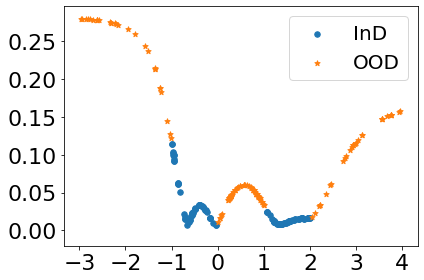

19 E-vecs: AUC = 0.91


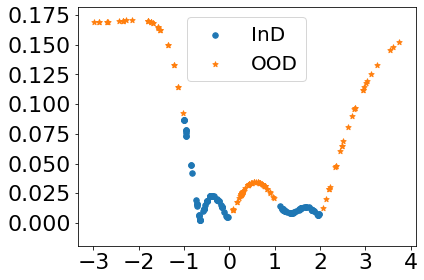

20 E-vecs: AUC = 0.91


In [10]:
numvals = 10
aucs = []
for cutoff in range(A_evecs.shape[1]):
    big_est_evecs = A_evecs[:,:cutoff]
    res = {}
    for itr, nm in [(itr_test, 'test'), (itr_ood, 'ood')]:
        small_grad_norms = []
        x = []
        for _ in range(4):
            xb, _ = itr.__next__()
            x.append(xb)
        x = np.concatenate(x, axis=0)
        # pred grads
        loss_grads = tu.flat_concat(so.get_pred_grads(x, pred_fn, map_grad_fn))
        proj_grads_coeff = np.matmul(loss_grads, big_est_evecs)
        proj_grads = np.matmul(proj_grads_coeff, big_est_evecs.T)
        proj_grads.shape

        small_grads = loss_grads - proj_grads
        small_grad_norms = np.linalg.norm(small_grads, axis=1, keepdims=True)
        res[nm] = (small_grad_norms, x)
    
    plt.scatter(res['test'][1], res['test'][0], label='InD', marker='o', s=markersize)
    plt.scatter(res['ood'][1], res['ood'][0], label='OOD', marker='*', s=markersize)
    plt.legend(prop={'size': legendsize})
    plt.xticks(fontsize=ticksize)
    plt.yticks(fontsize=ticksize)
    plt.tight_layout()
    plt.savefig(os.path.join(figdir, 'auc_{:d}.pdf'.format(cutoff)))
    plt.show()
    
    auc = eval_fns.get_auc(res['test'][0], res['ood'][0])
    aucs.append(auc)
    print('{:d} E-vecs: AUC = {:.2f}'.format(cutoff, auc))

We now plot the relationship between the estimate accuracy and the AUC achieved.
Sometimes, we can achieve higher AUC with very noisy estimates.

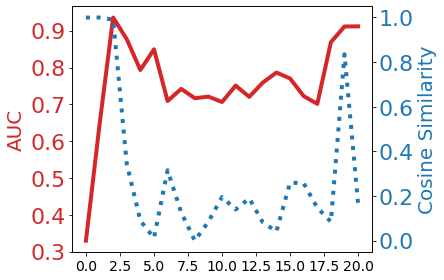

In [11]:
fig, ax1 = plt.subplots()
t = np.arange(len(angles))
color = 'tab:red'
# ax1.set_xlabel('Number of projections',  fontsize=15)
ax1.set_ylabel('AUC', color=color, fontsize=20)
ax1.plot(t, aucs, color=color, lw=4)
ax1.tick_params(axis='y', labelcolor=color)
plt.yticks(fontsize=ticksize)
plt.xticks(fontsize=ticksize - 8)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Cosine Similarity', color=color, fontsize=20)  # we already handled the x-label with ax1
ax2.plot(t, angles, color=color, ls=':', lw=4)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.yticks(fontsize=ticksize)
plt.savefig(os.path.join(figdir, 'auc_vs_angles.pdf'))
plt.show()

We find the scores from the highest-AUC run ...

In [13]:
cutoff = np.argmax(aucs)
print('Best AUC was with {:d} eigenvectors'.format(cutoff))
big_est_evecs = A_evecs[:,:cutoff]
res = {}
for itr, nm in [(itr_test, 'test'), (itr_ood, 'ood')]:
    small_grad_norms = []
    x = []
    for _ in range(4):
        xb, _ = itr.__next__()
        x.append(xb)
    x = np.concatenate(x, axis=0)
    loss_grads = tu.flat_concat(so.get_pred_grads(x, pred_fn, map_grad_fn))
    proj_grads_coeff = np.matmul(loss_grads, big_est_evecs)
    proj_grads = np.matmul(proj_grads_coeff, big_est_evecs.T)
    proj_grads.shape

    small_grads = loss_grads - proj_grads
    small_grad_norms = np.linalg.norm(small_grads, axis=1, keepdims=True)
    res[nm] = (small_grad_norms, x)



Best AUC was with 2 eigenvectors


... and plot the scores from this run against the input data, and the ensemble standard deviation.

<Figure size 432x288 with 0 Axes>

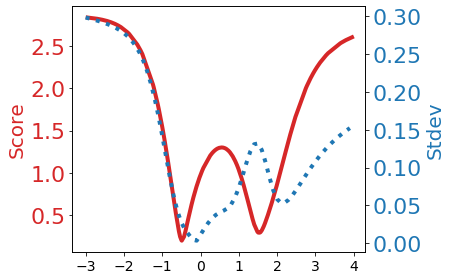

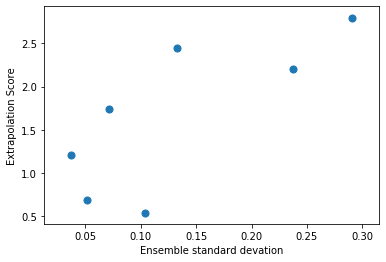

In [14]:
# Plot inputs vs. extrapolation score and ensemble standard deviation.
plt.clf()
res_x = np.concatenate([res['test'][1], res['ood'][1]], axis=0)
res_y = np.concatenate([res['test'][0], res['ood'][0]], axis=0)

res_x_list = [res_x[i] for i in range(len(res_x))]
res_y_list = [res_y[i] for i in range(len(res_y))]
res_sorted = sorted(zip(res_x_list, res_y_list), key=lambda p: p[0])
res_x = np.array([p[0] for p in res_sorted])
res_y = np.array([p[1] for p in res_sorted])

outputs = []
xrange = np.expand_dims(np.arange(-3, 4, 0.1), 1)
for mdl in ensemble:
    xrange_output, _ = mdl(xrange)
    outputs.append(xrange_output)
outputs = tf.concat(outputs, axis=1)
output_stdev = np.std(outputs, axis=1)

fig, ax1 = plt.subplots()
color = 'tab:red'
# ax1.set_xlabel('Number of projections',  fontsize=15)
ax1.set_ylabel('Score', color=color, fontsize=20)
ax1.plot(res_x, res_y, color=color, lw=4)
ax1.tick_params(axis='y', labelcolor=color)
plt.yticks(fontsize=ticksize)
plt.xticks(fontsize=ticksize - 8)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Stdev', color=color, fontsize=20)  # we already handled the x-label with ax1
ax2.plot(xrange, output_stdev, color=color, ls=':', lw=4)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.yticks(fontsize=ticksize)
plt.savefig(os.path.join(figdir, 'score_vs_stdev.pdf'))
plt.show()

# Plot ensemble standard deviation vs. extrapolation scores.
plt.clf()

# bin the data by input value to get a scatter plot
def inbin(x, lo, hi):
    return np.logical_and(x.flatten() >= lo, x.flatten() < hi)

bins_lo = np.arange(-3, 4)
bins_hi = bins_lo + 1
stdevs_in_bin = [np.mean(output_stdev[inbin(xrange, bins_lo[i], bins_hi[i])]) 
                    for i in range(len(bins_lo))]
scores_in_bin = [np.mean(res_y[inbin(res_x, bins_lo[i], bins_hi[i])])
                    for i in range(len(bins_lo))]
plt.scatter(stdevs_in_bin, scores_in_bin, s=50)
plt.xlabel('Ensemble standard devation')
plt.ylabel('Extrapolation Score')
plt.show()
